In [1]:
%matplotlib inline

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import os
import pandas as pd

from ruamel.yaml import YAML
from scipy.stats import entropy
from glob import glob
from tqdm.auto import tqdm
from moseq2_viz.model.util import (parse_model_results,
                                   labels_to_changepoints)
from moseq2_viz.util import load_changepoints

In [3]:
sns.set_style('white')
sns.set_context('notebook')

In [4]:
# jensen-shannon-divergence, a simple symmetrized probability distance metric...
# https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
def jsd(dist1, dist2, base=2):
    
    p = np.asarray(dist1)
    p /= p.sum()
    q = np.asarray(dist2)
    p /= q.sum()
    
    m = p + q
    
    return .5 * entropy(p, m, base=base) + .5 * entropy(q, m, base=base)

## Assume we've fit multiple models, scanning across different kappa values

### Load in the model fits, which are now all in one directory

In [5]:
# where did we stash our model fits?
model_fits_dir = "/home/markowitzmeister_gmail_com/modeling_results/dls_lesion_grooming_moseq2/batchjob_2019-07-27_21-23-21/"

# where does the original data live?
data_path = "/home/markowitzmeister_gmail_com/raw_data/dls_lesion_grooming_moseq2/"

# path to the pca results
pca_path = os.path.join(data_path, "_pca")

# path to the changepoints
changepoints_path = os.path.join(pca_path, "changepoints.h5")

# use the helper function to load in the model-free changepoints, which returns an array of durations
cps = load_changepoints(changepoints_path)

In [6]:
jobs = sorted(glob(os.path.join(model_fits_dir, '*.p')))
job_dcts = []
cp_dcts = []

# we'll keep these parameters for later
save_parameters = ['kappa', 'alpha', 'gamma']

# bins (in seconds) for evaluating distance between changepoints between model and model-free methods
bins = np.linspace(0, 5, 50)

for job in tqdm(jobs):
    
    # parse the model results with the helper function
    tmp = parse_model_results(job)
    
    model_labels, loglikes, heldout_lls, model_parameters =\
        tmp['labels'], tmp['loglikes'], tmp['heldout_ll'], tmp['model_parameters']
    
    # model-based changepoints
    model_cps = labels_to_changepoints(np.array(model_labels, dtype='object'))
    
    new_dct = {key: model_parameters[key] for key in save_parameters}
    new_dct['loglikelihood'] = loglikes[-1][0]
    new_dct['filename'] = job
    
    # need to bin for JSD
    nx = np.histogram(model_cps, bins)[0].astype('float')
    ny = np.histogram(cps, bins)[0].astype('float')    
    new_dct['jsd'] = jsd(nx ,ny)
    
    if len(heldout_lls) > 0:
        new_dct['heldout_ll'] = np.mean(heldout_lls)
    job_dcts.append(new_dct)
df = pd.DataFrame(job_dcts)

### Plot a simple metric comparing the model-based changepoints to the model-free estimate

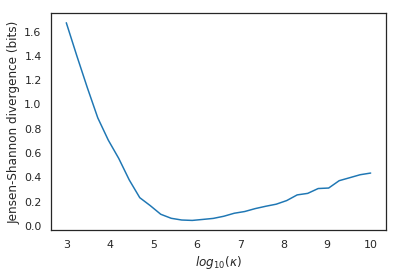

In [7]:
# assuming we tried different values of kappa, plot JSD against kappa
plt.plot(df["kappa"].apply(np.log10), df["jsd"])
plt.ylabel("Jensen-Shannon divergence (bits)")
plt.xlabel(r"$log_{10}(\kappa)$")
plt.show()

In [8]:
# load in the best model, which minimizes JSD
best_model = df.loc[df["jsd"].idxmin(), "filename"]
worst_model = df.loc[df["jsd"].idxmax(), "filename"]
best_model = parse_model_results(best_model)
worst_model = parse_model_results(worst_model)
best_model_changepoints = labels_to_changepoints(best_model['labels'])
worst_model_changepoints = labels_to_changepoints(worst_model['labels'])

### Visualize the best and worst models

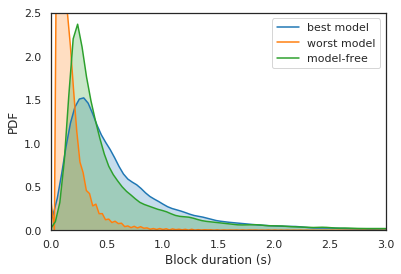

In [10]:
# plot model-based and model-free changepoints
kde_kws = {'shade': True,
           'gridsize': 250,
           'clip': (0, 10)}
sns.distplot(best_model_changepoints, label="best model", hist=False, kde_kws=kde_kws)
sns.distplot(worst_model_changepoints, label="worst model", hist=False, kde_kws=kde_kws)
sns.distplot(cps, label="model-free", hist=False, kde_kws=kde_kws)
plt.xlabel('Block duration (s)')
plt.ylabel('PDF')
plt.xlim(0, 3)
plt.ylim(0, 2.5)
plt.legend()
plt.show()